# ADA Assignment 1

- Sampad Kumar Kar
- MCS202215

# 0. Imports

In [1]:
# for file handling
import os, sys

# for data manipulation
import pandas as pd
import numpy as np

# for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Data Loading

In [2]:
# .xlxs file converted to .csv file

data_path = os.path.join('data', 'raw', 'FabricLink_Cleaned_Data_25_July.csv')

# read the data as a dataframe
df = pd.read_csv(data_path)

# print the first 5 rows of the dataframe
df.head()

,source_node,source_port,source_type,source_value,operSpeed,operSt,destination_node,destination_port,destination_type,destination_value,octets,lastOctetval,Octet-diff,Utilization,datetime
0,1001,1/1,spine,N9K-C9372PX-E,40G,up,401,1/49,leaf,N9K-C9508,8.645044e+14,8.593656e+14,5138780418132,454.98,2022-05-13 19:07:34
1,1001,1/1,spine,N9K-C9372PX-E,40G,up,401,1/49,leaf,N9K-C9508,8.683097e+14,8.645044e+14,3805258585956,336.04,2022-05-14 19:07:27
2,1001,1/1,spine,N9K-C9372PX-E,40G,up,401,1/49,leaf,N9K-C9508,8.733733e+14,8.683097e+14,5063626383956,446.94,2022-05-15 19:08:04
3,1001,1/1,spine,N9K-C9372PX-E,40G,up,401,1/49,leaf,N9K-C9508,8.789338e+14,8.733733e+14,5560535345898,491.01,2022-05-16 19:08:05
4,1001,1/1,spine,N9K-C9372PX-E,40G,up,401,1/49,leaf,N9K-C9508,8.846940e+14,8.789338e+14,5760175669592,508.51,2022-05-17 19:08:27


In [3]:
df.columns

Index(['source_node', 'source_port', 'source_type', 'source_value',
       'operSpeed', 'operSt', 'destination_node', 'destination_port',
       'destination_type', 'destination_value', 'octets', 'lastOctetval',
       'Octet-diff', 'Utilization', 'datetime'],
      dtype='object')

In [4]:
# filter dataframe to store only the required columns, i.e. 'source_node', 'destination_node', 'Utilization', 'datetime'
df = df[['source_node', 'destination_node', 'Utilization', 'datetime']]

# change the 'datetime' column to datetime format
df['datetime'] = pd.to_datetime(df['datetime'])

df.head()

,source_node,destination_node,Utilization,datetime
0,1001,401,454.98,2022-05-13 19:07:34
1,1001,401,336.04,2022-05-14 19:07:27
2,1001,401,446.94,2022-05-15 19:08:04
3,1001,401,491.01,2022-05-16 19:08:05
4,1001,401,508.51,2022-05-17 19:08:27


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19320 entries, 0 to 19319
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   source_node       19320 non-null  int64         
 1   destination_node  19320 non-null  int64         
 2   Utilization       19320 non-null  float64       
 3   datetime          19320 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 603.9 KB


# 2. EDA

In [10]:
# variables to store the unique source and destination nodes
source_nodes = df['source_node'].unique()
destination_nodes = df['destination_node'].unique()

print('Number of unique source nodes: ', len(source_nodes))
print('Number of unique destination nodes: ', len(destination_nodes))

Number of unique source nodes:  74
Number of unique destination nodes:  75


In [19]:
# analysis on link utilization
link_utilization = df.groupby(['source_node', 'destination_node'])

print("Total number of links: ", len(link_utilization))

Total number of links:  290


In [35]:
# identifying links with maximum, minimum average utilization
link_utilization_mean = link_utilization.mean()
link_utilization_mean = link_utilization_mean.sort_values(by='Utilization', ascending=False)

print("Link with maximum average utilization: ", link_utilization_mean.index[0], link_utilization_mean.iloc[0]['Utilization'])
print("Link with minimum average utilization: ", link_utilization_mean.index[-1], link_utilization_mean.iloc[-1]['Utilization'])
print("Avergae Utilization over all the links: ", df['Utilization'].mean())

Link with maximum average utilization:  (992, 1002) 4064.3906944444443
Link with minimum average utilization:  (502, 2) 0.0
Avergae Utilization over all the links:  460.23339751552794


We plot a heatmap with the horizantal axis consisting of `'source_node'` values in ascending order and vertical axis consisting of `'destination_node'` values in ascending order, with each corresponding cell color coded proportional to the average `'Utilization'` value for the corresponding link/ `(source_node, destination_node)` pair.

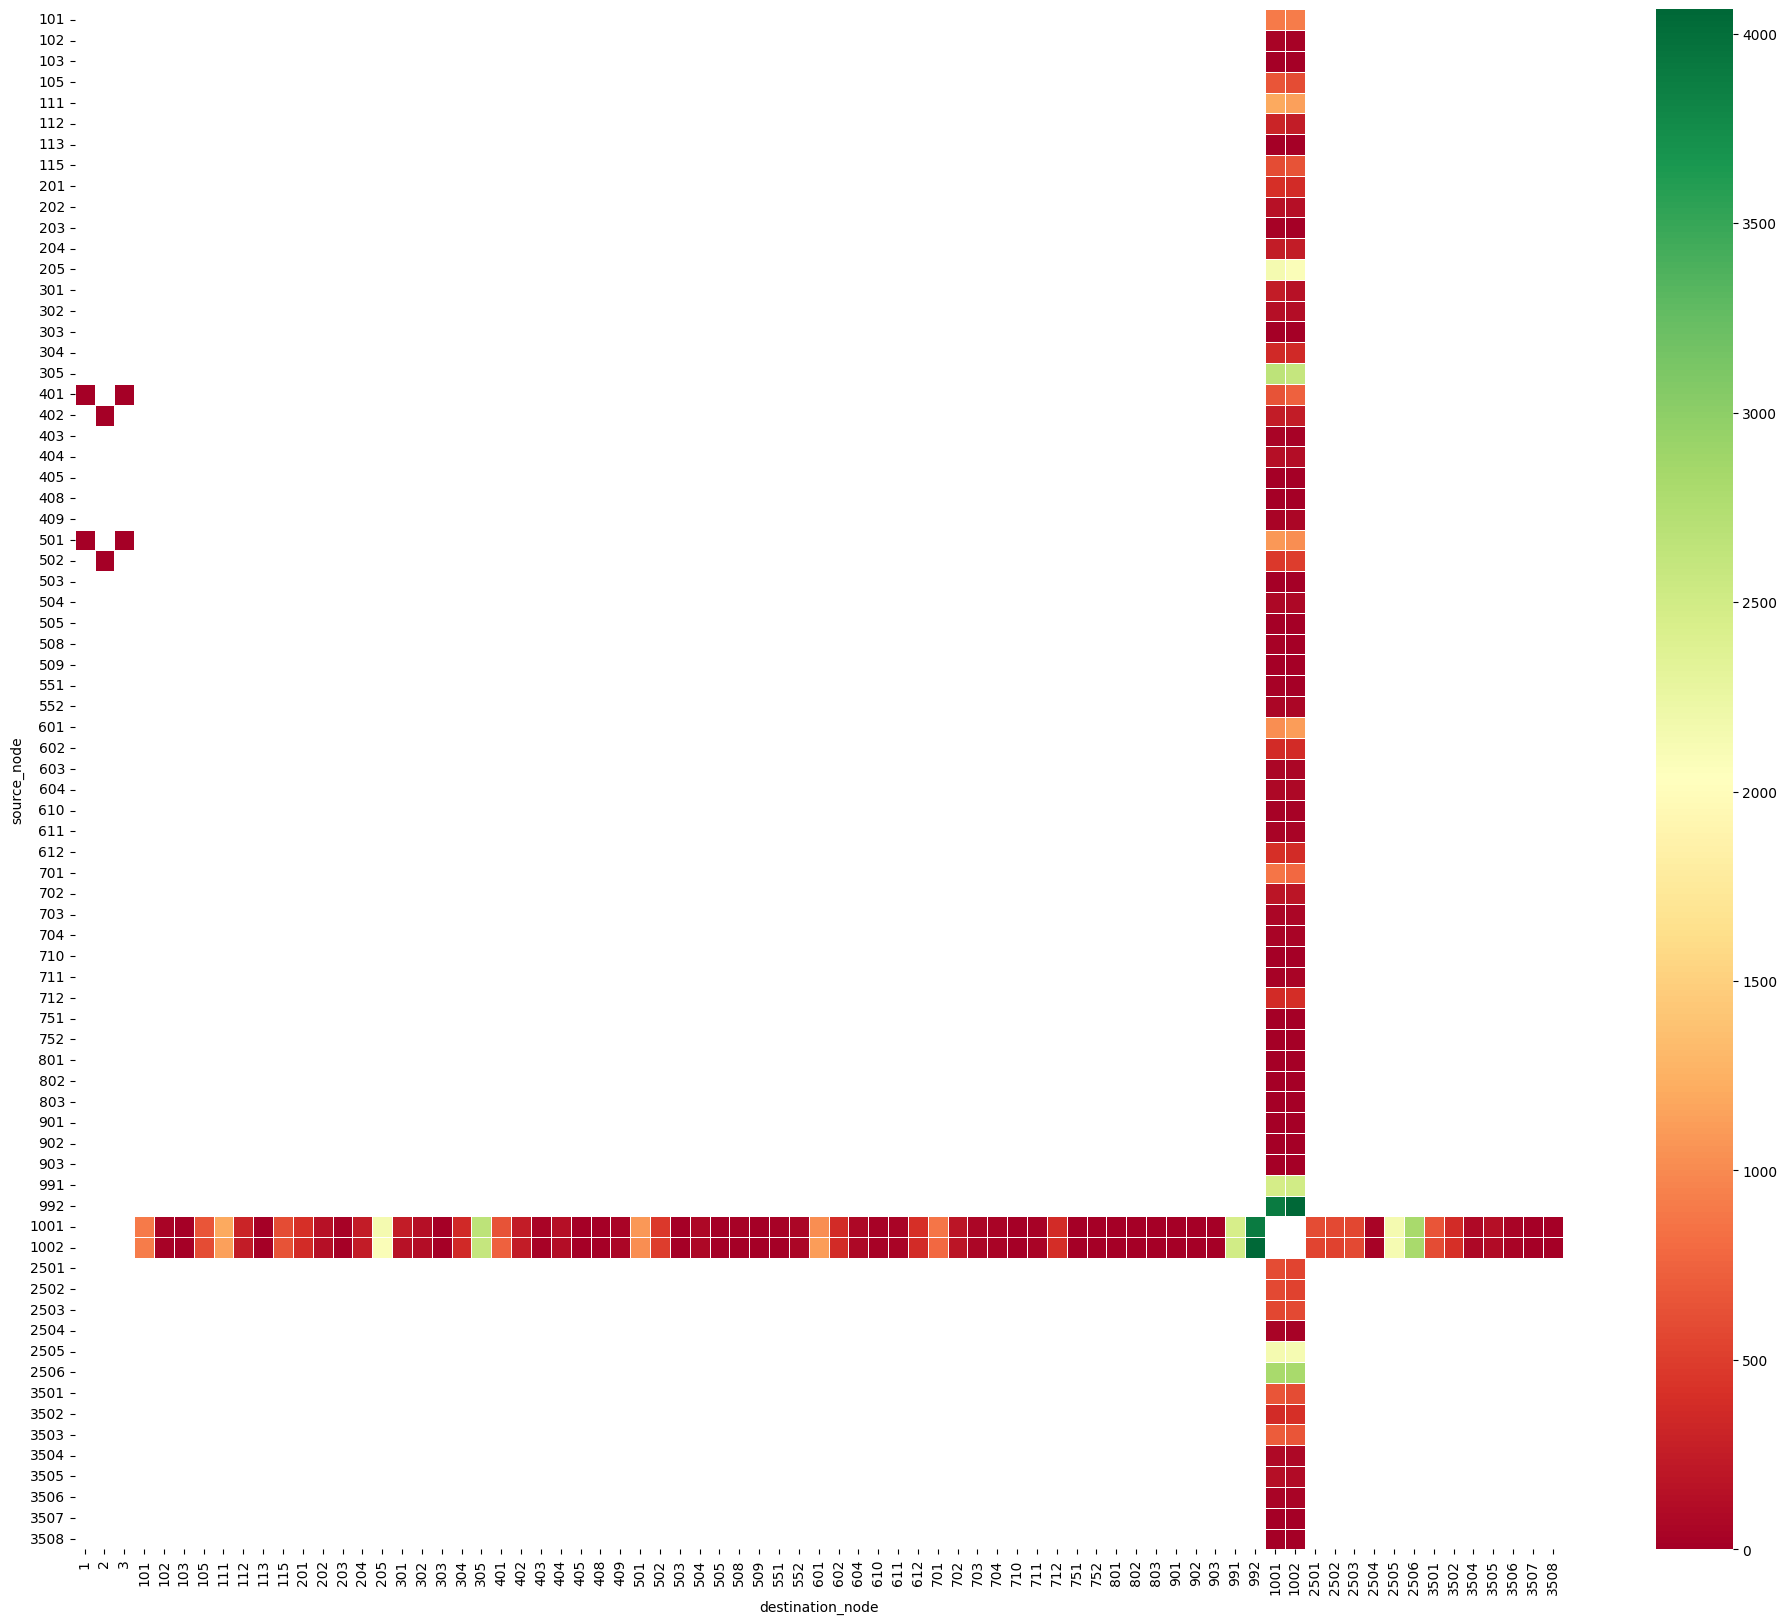

In [39]:
# create a pivot table with 'source_node' as the index, 'destination_node' as the columns and 'Utilization' as the values
link_utilization_mean_pivot = link_utilization_mean.pivot_table(index='source_node', columns='destination_node', values='Utilization')

# plot the pivot table as a heatmap
plt.figure(figsize=(24, 20))
sns.heatmap(link_utilization_mean_pivot, cmap='RdYlGn', annot=False, fmt='.2f', linewidths=0.5)
plt.show()

Based on the above heatmap, we can infer that most of the links are one of the following types:
- `(1001, y)`
- `(1002, y)`
- `(x, 1001)`
- `(x, 1002)`

where `x` belongs to the set of all unique `source_node` values and `y` belongs to the set of all unique `destination_node` values (both without the values `1001` and `1002`).

We can also observe that the Links of the type `(1001, 100n+1), (1002, 100n+1), (100n+1, 1001), (100n+1, 1002)` have comparitively lower average `'Utilization'` values compared to other Links.

## Q.1. Identifying Similar Links

Based on the heatmap above we decide to group and analyse these links by observing their plots of `'Utilization'` values over time.

- Orange:
`
(1001, 101)
(1002, 101)
(1001, 501)
(1002, 501)
`

- Green:
`
(305, 1001)
(305, 1002)
(2506, 1001)
(2506, 1002)
`

- Maroon:
`
(3508, 1001)
(3508, 1002)
(1001, 102)
(1002, 102)
`

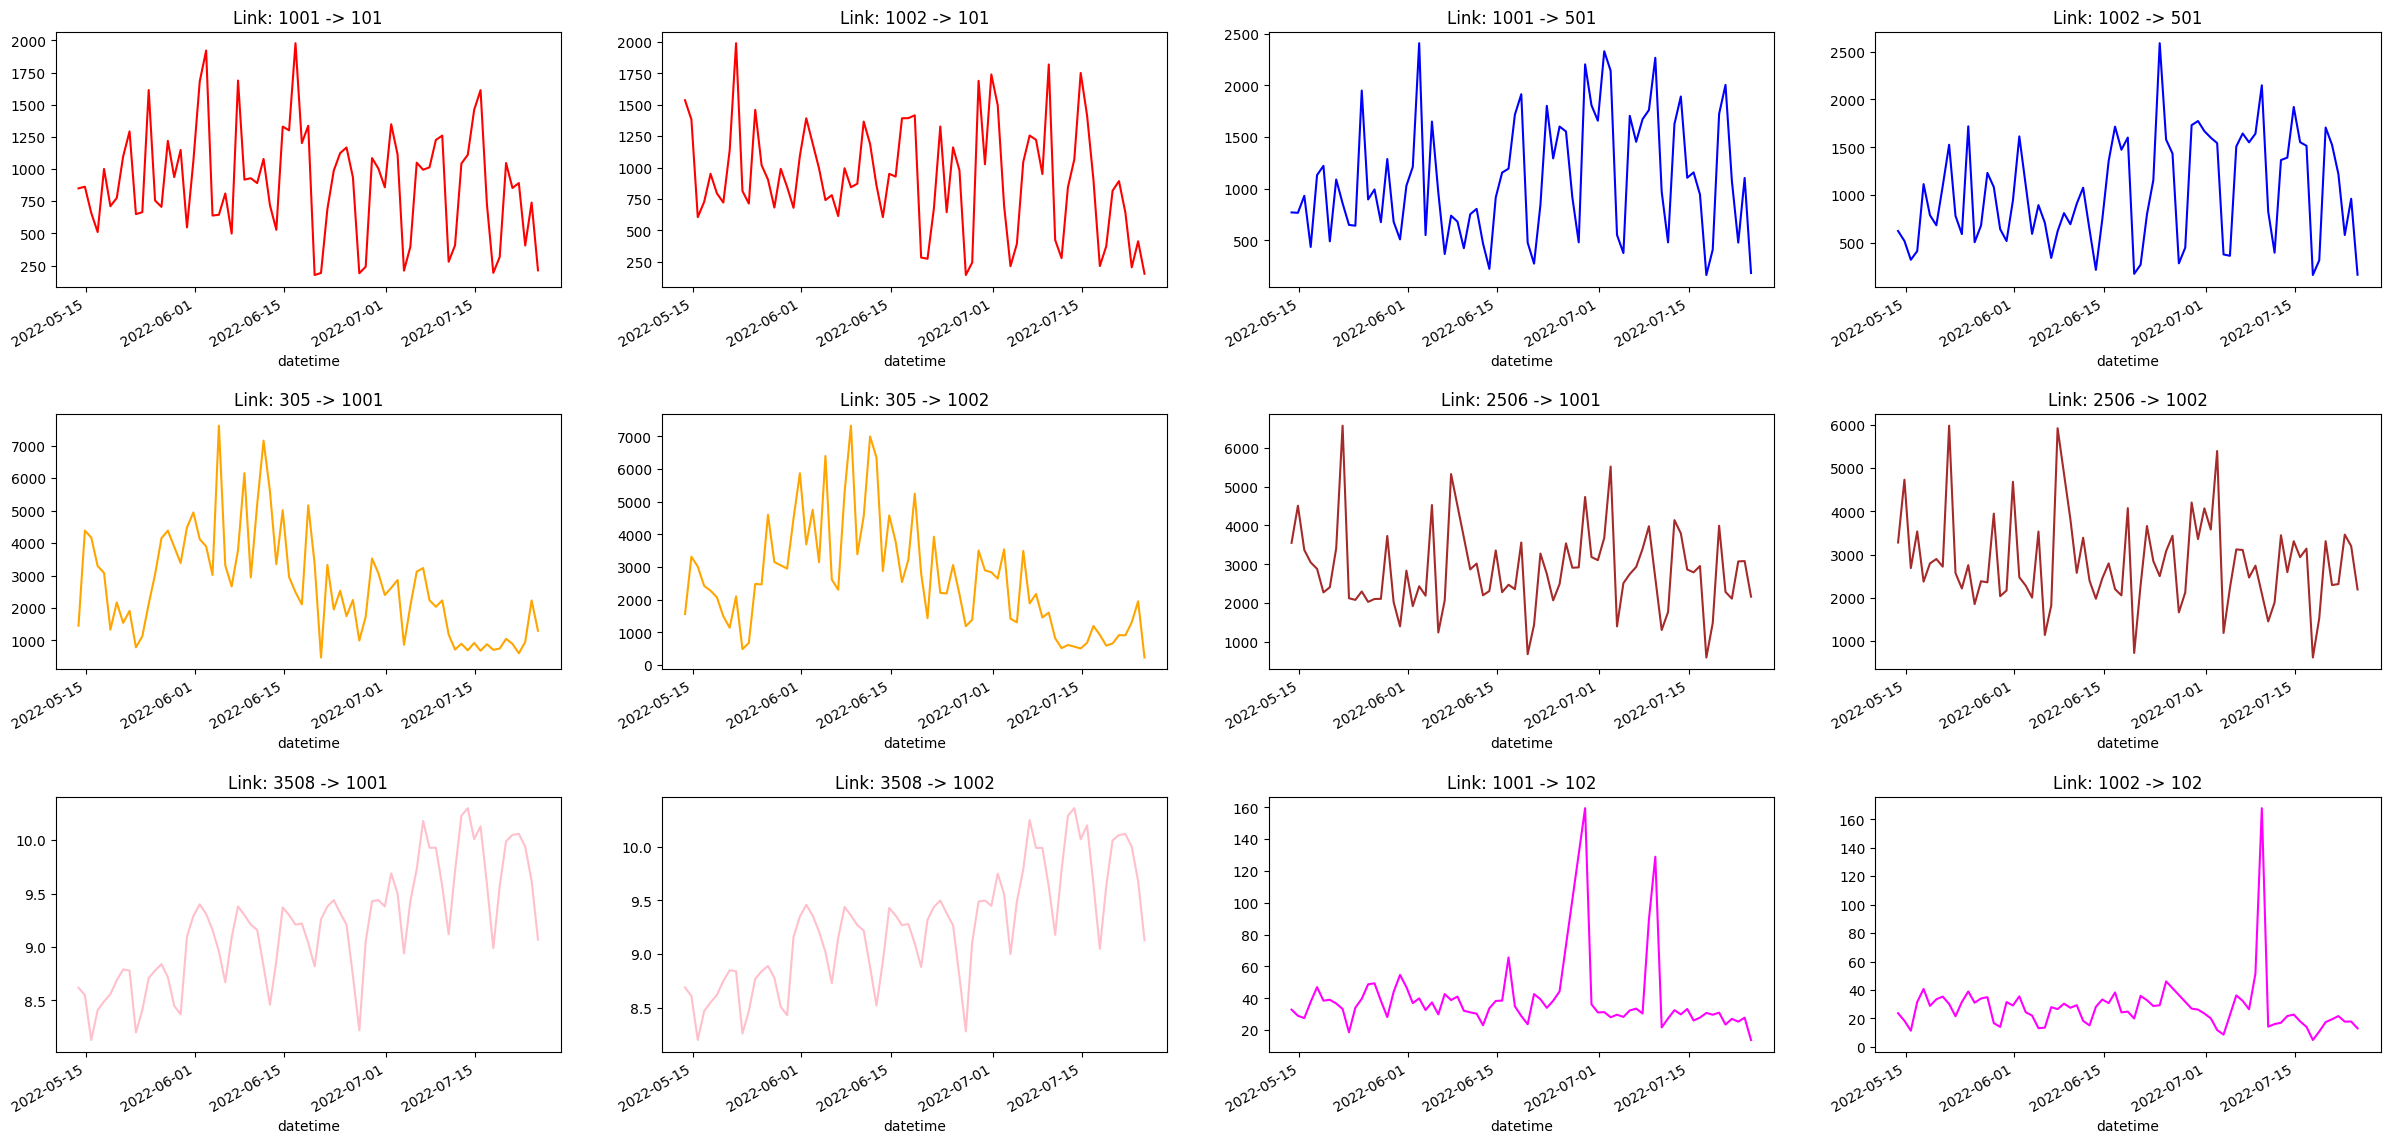

In [64]:
# create a list of 12 links we want to plot

links = [(1001, 101), (1002, 101), (1001, 501), (1002, 501), (305, 1001), (305, 1002), 
(2506, 1001), (2506, 1002), (3508, 1001), (3508, 1002), (1001, 102), (1002, 102)]

# plot colors
colors_list = ['red', 'red', 'blue', 'blue', 'orange', 'orange', 'brown', 'brown', 'pink', 'pink', 'magenta', 'magenta']

# plot the 'Utilization' vs 'datetime' for the above links in a 3*4 grid
fig, axes = plt.subplots(3, 4, figsize=(30, 15))

# increase the space between the subplots
plt.subplots_adjust(hspace=0.5)

for i, link in enumerate(links):
    # color the plots based on colors_list
    link_df = df[(df['source_node'] == link[0]) & (df['destination_node'] == link[1])]

    # plot the 'Utilization' vs 'datetime' for the link
    link_df.plot(x='datetime', y='Utilization', ax=axes[i//4, i%4], title='Link: ' + str(link[0]) + ' -> ' + str(link[1]), legend=False, color=colors_list[i])

plt.show()

As we can observe from the above plot, the links plotted with similar colors have similar patterns of `'Utilization'` values over time.

## Q.2. Identifying Weekday and Weekend Patterns

We group the observations of the `'Utilization'` column based on days of the weeks and plot the corresponding stripplots to observe the usage patterns.

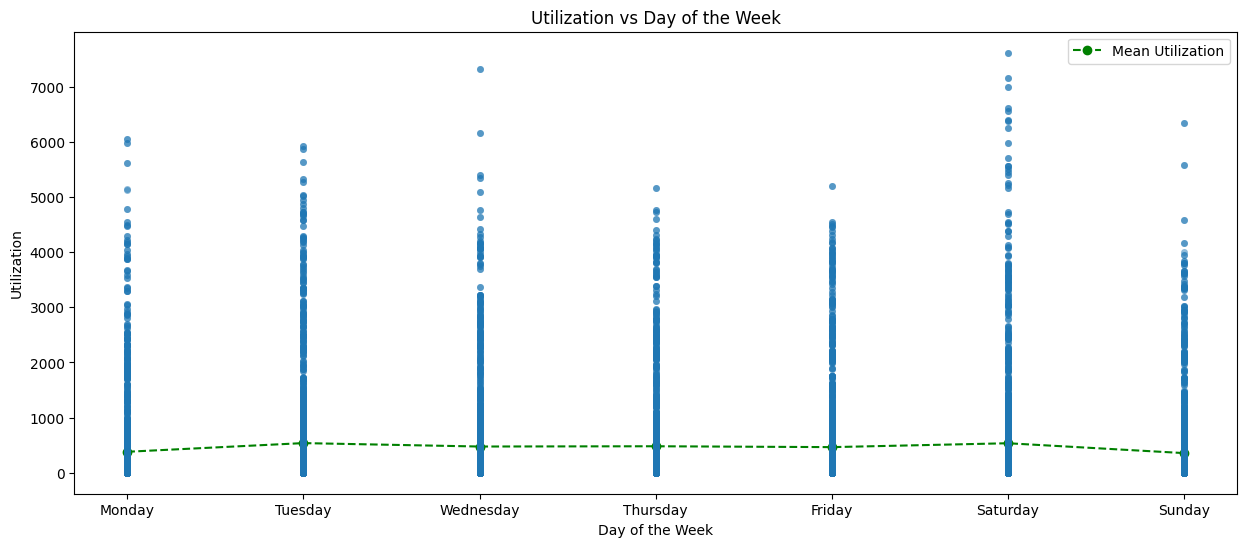

In [75]:
# plot the stripplot based on the days of the week by looking at the 'Utilization' and 'datetime' columns

# create a copy of the dataframe
df_copy = df.copy()

# create a new column 'day_of_week' to store the day of the week
df_copy['day_of_week'] = df_copy['datetime'].dt.day_name()

daysofweek_list = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# sort the dataframe based on the day of the week in the order 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
df_copy['day_of_week'] = pd.Categorical(df_copy['day_of_week'], categories=daysofweek_list, ordered=True)

# calculate the mean utilization for each day of the week
mean_deposits_by_day = df_copy.groupby('day_of_week')['Utilization'].mean()

# create the plots
plt.figure(figsize=(15, 6))

# plot the stripplot
sns.stripplot(x='day_of_week', y='Utilization', data=df_copy, jitter=False, alpha=0.5)

# plot the mean utilization
plt.plot(mean_deposits_by_day.index, mean_deposits_by_day.values, color='green', linestyle='--', marker='o', label='Mean Utilization')

# set the title and labels
plt.title('Utilization vs Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Utilization')

# set the legend
plt.legend()

plt.show()

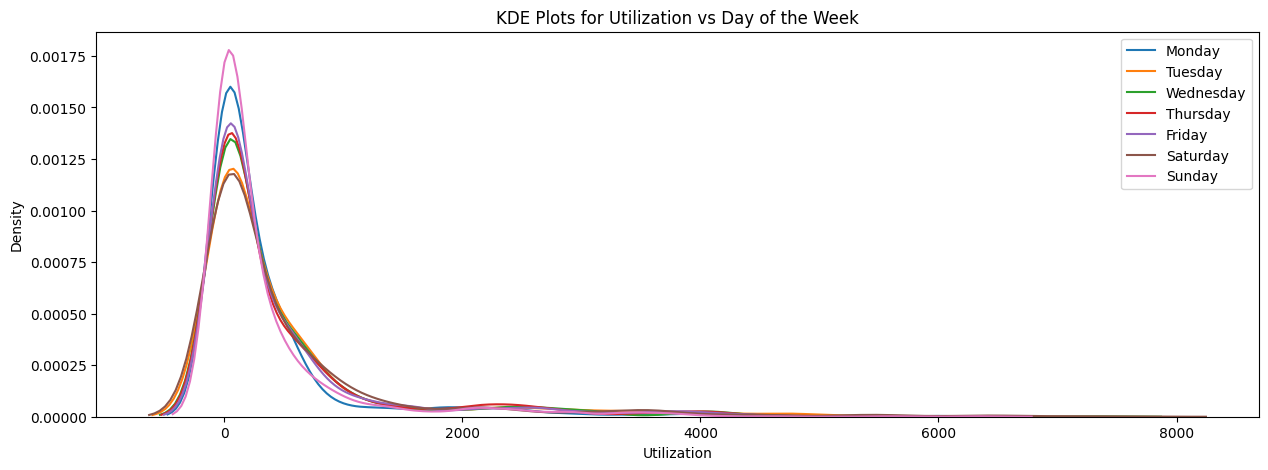

In [80]:
# plot KDE for the Utilization wrt days of the week

# create the plots
plt.figure(figsize=(15, 5))

# plot the KDE plot
for week in daysofweek_list:
    sns.kdeplot(df_copy[df_copy['day_of_week'] == week]['Utilization'], label=week)

# set the title and labels
plt.title('KDE Plots for Utilization vs Day of the Week')
plt.xlabel('Utilization')
plt.ylabel('Density')

# set the legend
plt.legend()

plt.show()

Based on the KDE plots, we can infer that the Bandwidth utilization has higher peaks on `Sunday` compared to remaining days of the week. The next highest peaks are observed on `Monday` and `Friday` respectively.

## Q.3. Inferences from the above EDAs

Based on the links heatmap, we can infer that most of the links are one of the following types:
- `(1001, y)`
- `(1002, y)`
- `(x, 1001)`
- `(x, 1002)`

where `x` belongs to the set of all unique `source_node` values and `y` belongs to the set of all unique `destination_node` values (both without the values `1001` and `1002`).

We can also observe that the Links of the type `(1001, 100n+1), (1002, 100n+1), (100n+1, 1001), (100n+1, 1002)` have comparitively lower average `'Utilization'` values compared to other Links.


Also following link pairs of the following form have typically similar `'Utilization'` value distribution with each other:
- `(1001, y)`, `(1002, y)`
- `(x, 1001)`, `(x, 1002)`

Based on the KDE plots, we can infer that the Bandwidth utilization has higher peaks on `Sunday` compared to remaining days of the week. The next highest peaks are observed on `Monday` and `Friday` respectively.

This might be due to the fact that the Bandwidth utilization is typically higher on or near weekends compared to regular weekdays.

## Q.4. Analysis of Bandwidth Utilization

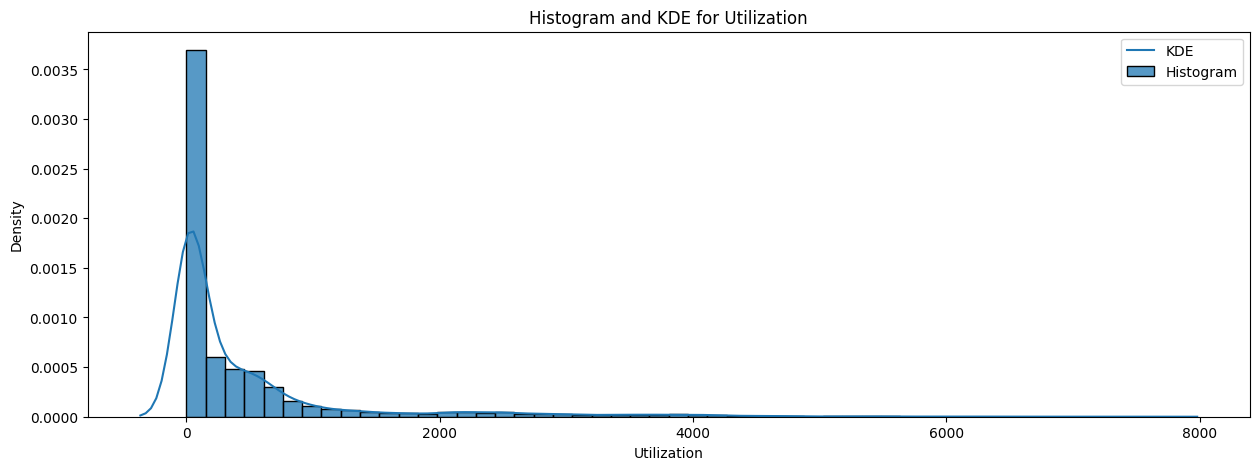

In [88]:
# plot the histogram and corresponding KDE for the Utilization

# create the plots
plt.figure(figsize=(15, 5))

# plot the histogram
sns.histplot(df_copy['Utilization'], bins=50, kde=False, stat='density', label='Histogram')

# plot the KDE plot
sns.kdeplot(df_copy['Utilization'], label='KDE')

# set the title and labels
plt.title('Histogram and KDE for Utilization')
plt.xlabel('Utilization')
plt.ylabel('Density')

# set the legend
plt.legend()

plt.show()

In [92]:
# print the skewness and kurtosis of the 'Utilization' column
print("Skewness of Utilization: ", df_copy['Utilization'].skew())
print("Kurtosis of Utilization: ", df_copy['Utilization'].kurt())

Skewness of Utilization:  3.1293905710125136
Kurtosis of Utilization:  11.262711783585626


In [89]:
# find the summary of the 'Utilization' column
df_copy['Utilization'].describe()

count    19320.000000
mean       460.233398
std        870.972492
min          0.000000
25%         10.120000
50%         86.100000
75%        508.632500
max       7616.030000
Name: Utilization, dtype: float64

As we can see from this plot, this appears to be long tailed distribution, which the **right skewed** (i.e. tails is towards the right).
Also, as evident by a skewness value of `3.12` and a kurtosis value of `11.26` we can infer that the distribution has a long right tail and is **leptokurtic** (i.e. has a higher peak and heavier tails compared to a normal distribution).

Also the maximum utilization seems to be around `7616 Mbps` which is equivalent to `7616/1000 = 7.616 Gbps` which is less than the upper limit of `10 Gbps` for the links.